# Denoising using AutoEncoders

### Setup notebook

In [6]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from model import AutoEncoderCNN
from utils import add_noise, train, test


In [7]:
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)


1.9.0+cu111
cuda:0


## MIAS Dataset

### Download & extract the dataset

In [8]:
MIAS_URL = "http://peipa.essex.ac.uk/pix/mias/all-mias.tar.gz"
MIAS_DATASET_DIR = Path("./datasets/mias")
MIAS_MODEL_DIR = Path("./models/mias")

if not MIAS_DATASET_DIR.exists():
    !mkdir {MIAS_DATASET_DIR / 'all-mias'}
    !wget -P {MIAS_DATASET_DIR} {MIAS_URL}
    !tar -xf {MIAS_DATASET_DIR / "all-mias.tar.gz"} --directory {MIAS_DATASET_DIR / 'all-mias'}

if not MIAS_MODEL_DIR.exists():
    !mkdir {MIAS_MODEL_DIR}


### Setup training and testing sets

In [9]:
FEATURE_SHAPE = 64
BATCH_SIZE = 10
TRAIN_TEST_SPLIT = 0.9

# ? Resize the images and convert to grayscale tensors
transform = transforms.Compose(
    [
        transforms.Resize(FEATURE_SHAPE),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ]
)

dataset = datasets.ImageFolder(MIAS_DATASET_DIR, transform)

# ? Split dataset into train and test sets
train_size = int(TRAIN_TEST_SPLIT * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# ? Create dataset loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


### Visualize dataset

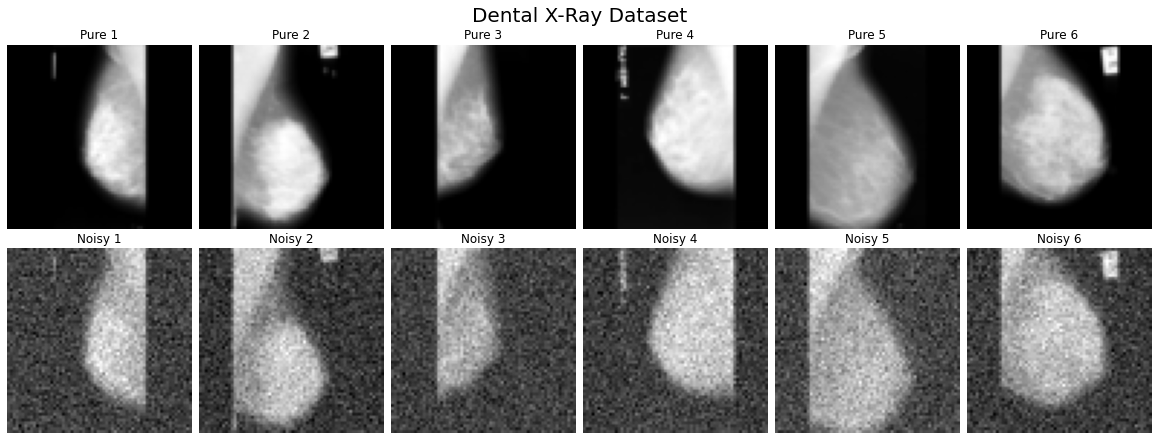

In [13]:
fig, axes = plt.subplots(2, 6, figsize=(16, 6), constrained_layout=True)
axes = list(map(list, zip(*axes)))
fig.suptitle("MIAS Dataset", fontsize=20)

for i, (ax1, ax2) in enumerate(axes):
    fig_img, _ = train_dataset[i]
    fig_img = fig_img.permute(1, 2, 0)

    ax1.imshow(fig_img, cmap="gray")
    ax1.axis("off")
    ax1.set_title(f"Pure {i+1}")

    fig_img = add_noise(fig_img)
    ax2.imshow(fig_img, cmap="gray")
    ax2.axis("off")
    ax2.set_title(f"Noisy {i+1}")


### Build & Train CNN based AutoEncoder Model

<generator object Module.parameters at 0x0000021AEF4B47B0>
Training started...


C:\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1	[0/289 (0%)]	Loss: 0.068325
Epoch: 1	[100/289 (34%)]	Loss: 0.030490
Epoch: 1	[200/289 (69%)]	Loss: 0.033619
Epoch: 2	[0/289 (0%)]	Loss: 0.028813
Epoch: 2	[100/289 (34%)]	Loss: 0.025288
Epoch: 2	[200/289 (69%)]	Loss: 0.028065
Epoch: 3	[0/289 (0%)]	Loss: 0.023568
Epoch: 3	[100/289 (34%)]	Loss: 0.026996
Epoch: 3	[200/289 (69%)]	Loss: 0.027887
Epoch: 4	[0/289 (0%)]	Loss: 0.024031
Epoch: 4	[100/289 (34%)]	Loss: 0.026417
Epoch: 4	[200/289 (69%)]	Loss: 0.027909
Epoch: 5	[0/289 (0%)]	Loss: 0.026418
Epoch: 5	[100/289 (34%)]	Loss: 0.020813
Epoch: 5	[200/289 (69%)]	Loss: 0.024418
Epoch: 6	[0/289 (0%)]	Loss: 0.022746
Epoch: 6	[100/289 (34%)]	Loss: 0.029073
Epoch: 6	[200/289 (69%)]	Loss: 0.025889
Epoch: 7	[0/289 (0%)]	Loss: 0.030707
Epoch: 7	[100/289 (34%)]	Loss: 0.022094
Epoch: 7	[200/289 (69%)]	Loss: 0.026982
Epoch: 8	[0/289 (0%)]	Loss: 0.025356
Epoch: 8	[100/289 (34%)]	Loss: 0.026961
Epoch: 8	[200/289 (69%)]	Loss: 0.023076
Epoch: 9	[0/289 (0%)]	Loss: 0.027849
Epoch: 9	[100/289 (34%)]	Lo

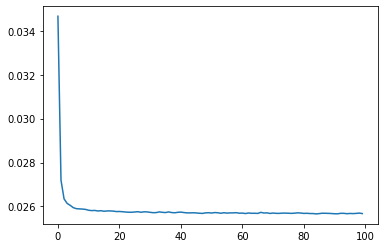

In [12]:
model = AutoEncoderCNN()
model.to(device)
print(model.parameters())

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

train_losses = train(
    model,
    train_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=100,
    device=device,
    save_dir=MIAS_MODEL_DIR,
)

plt.plot(train_losses)


### Test the model


In [14]:
model = AutoEncoderCNN()
model.load_state_dict(torch.load(MIAS_MODEL_DIR / "autoencodercnn_epoch_100.pth"))
model.to(device)

noisy_imgs, denoised_imgs = test(model, test_loader, criterion=criterion, device=device)


Average test loss: 0.032068


### Visualize results

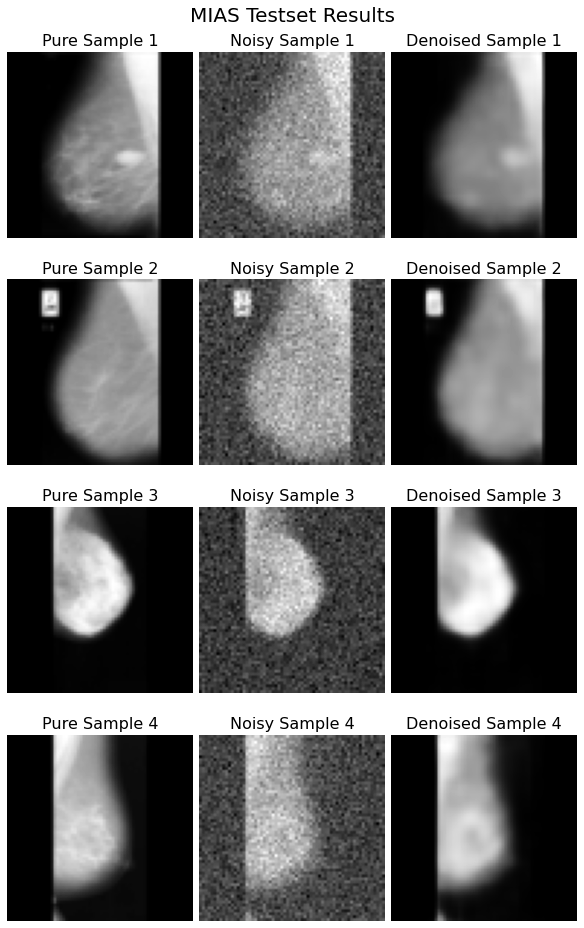

In [25]:
fig, axes = plt.subplots(4, 3, figsize=(8, 13), constrained_layout=True)
fig.suptitle("MIAS Testset Results", fontsize=20)

for i, ax in enumerate(axes):
    ax[0].imshow(test_dataset[i][0].permute(1, 2, 0), cmap="gray")
    ax[0].axis("off")
    ax[0].set_title(f"Pure Sample {i+1}", fontsize=16)

    ax[1].imshow(noisy_imgs[i].permute(1, 2, 0), cmap="gray")
    ax[1].axis("off")
    ax[1].set_title(f"Noisy Sample {i+1}", fontsize=16)

    ax[2].imshow(denoised_imgs[i].permute(1, 2, 0), cmap="gray")
    ax[2].axis("off")
    ax[2].set_title(f"Denoised Sample {i+1}", fontsize=16)
